# Baseline with SMOTE

In [1]:
%load_ext autoreload
%autoreload 2
#%reload_ext autoreload
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import folium
import geopandas
import geopy
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import linear_rainbow, het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_squared_error, make_scorer
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import folium.plugins as plugins
import math
from math import sin, cos, sqrt, atan2, radians
from haversine import haversine
from itertools import combinations
import json
%matplotlib inline
pd.set_option("display.max_columns", 200)
pd.set_option("display.max_rows", 200)
import sys
import os
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.compose import make_column_selector
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from  sklearn.metrics import precision_recall_fscore_support, precision_recall_curve

## Load Data

In [2]:
df = pd.read_csv('../data/train.csv')
validate = pd.read_csv('../data/validate.csv')

df.head()

,longitude,latitude,basin,region,district_code,public_meeting,permit,extraction_type,management,payment,water_quality,quantity,source,waterpoint_type,pop_log,age,status_group
0,34.94,-9.86,Lake Nyasa,Iringa,DD5,True,False,gravity,vwc,pay annually,soft,enough,spring,communal standpipe,4.691348,12,functional
1,34.70,-2.15,Lake Victoria,Mara,DD2,True,True,gravity,wug,never pay,soft,insufficient,rainwater harvesting,communal standpipe,5.634790,3,functional
2,37.46,-3.82,Pangani,Manyara,DD4,True,True,gravity,vwc,pay per bucket,soft,enough,dam,communal standpipe multiple,5.521461,4,functional
3,38.49,-11.16,Ruvuma / Southern Coast,Mtwara,DD63,True,True,submersible,vwc,never pay,soft,dry,machine dbh,communal standpipe multiple,4.060443,27,non functional
4,31.13,-1.83,Lake Victoria,Kagera,DD1,True,True,gravity,other,never pay,soft,seasonal,rainwater harvesting,communal standpipe,6.092055,14,functional


## Split the Data

In [4]:
X = df.drop('status_group', axis=1)
y = df['status_group']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [9]:
from imblearn.pipeline import make_pipeline as mp
number_selector = make_column_selector(dtype_include='number', dtype_exclude=['object', 'bool'])
string_selector = make_column_selector(dtype_include=['object', 'bool'])

preprocessing = make_column_transformer((OneHotEncoder(handle_unknown='ignore'), string_selector),
                                        (StandardScaler(), number_selector),
                                       remainder='passthrough')

preprocessing2 = mp(preprocessing, SMOTE(random_state=42, n_jobs=-1, sampling_strategy='auto'))


logregsmote = mp(preprocessing,  SMOTE(random_state=42, n_jobs=-1, sampling_strategy='auto'), LogisticRegression(solver='saga', 
                            random_state=42, 
                            multi_class='ovr',
                            max_iter=10000,
                           n_jobs=-1), )

Checking the transformer is working correctly and evenly distributing the labels

In [6]:
_,__ = preprocessing2.fit_resample(X_train, y_train)

In [7]:
__.value_counts()

functional                 16207
functional needs repair    16207
non functional             16207
Name: status_group, dtype: int64

In [10]:
logregsmote.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000022D24D5A070>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000022D1C119BE0>)])),
                ('smote', SMOTE(n_jobs=-1, random_state=42)),
                ('logisticregression',
                 LogisticRegression(max_iter=10000, multi_class='ovr',
                                    n_jobs=-1, random_state=42,
                                    solver='saga'))])

In [11]:
y_hat_train = logregsmote.predict(X_train)
y_hat_test = logregsmote.predict(X_test)

In [12]:
print(classification_report(y_train, y_hat_train))

                         precision    recall  f1-score   support

             functional       0.79      0.63      0.70     16207
functional needs repair       0.20      0.67      0.30      2193
         non functional       0.78      0.64      0.70     11600

               accuracy                           0.64     30000
              macro avg       0.59      0.65      0.57     30000
           weighted avg       0.74      0.64      0.67     30000



In [13]:
print(classification_report(y_test, y_hat_test))

                         precision    recall  f1-score   support

             functional       0.80      0.63      0.70      5427
functional needs repair       0.20      0.65      0.31       754
         non functional       0.77      0.65      0.70      3819

               accuracy                           0.64     10000
              macro avg       0.59      0.64      0.57     10000
           weighted avg       0.74      0.64      0.67     10000



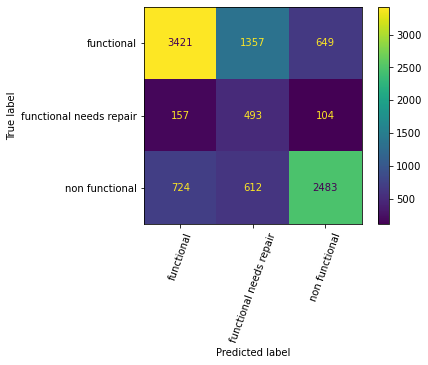

In [15]:
plot_confusion_matrix(logregsmote, X_test, y_test, xticks_rotation=70)  
plt.show() 

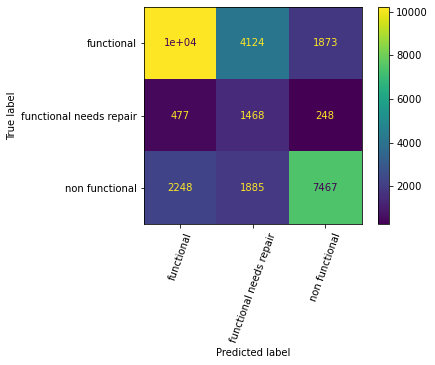

In [16]:
plot_confusion_matrix(logregsmote, X_train, y_train, xticks_rotation=70)  
plt.show() 

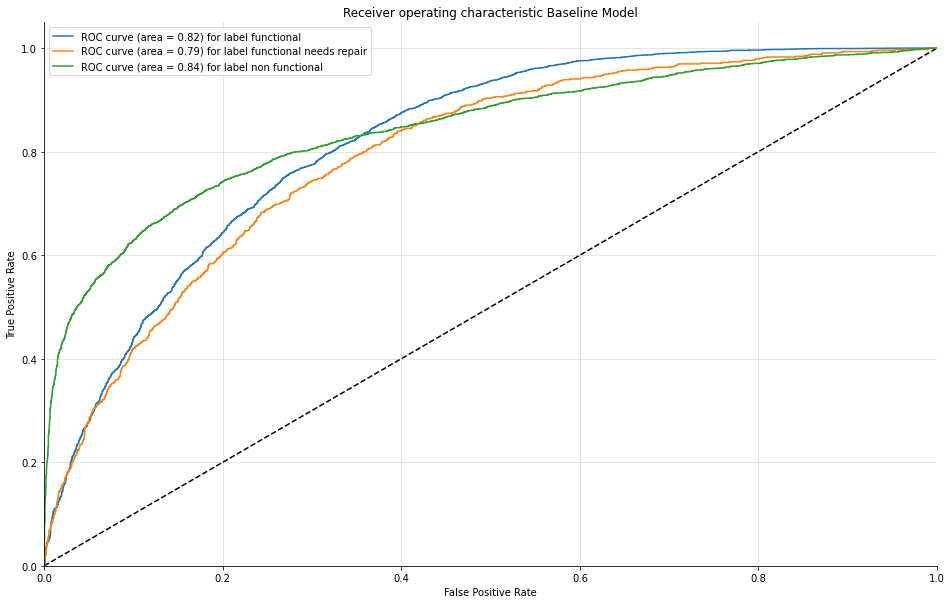

In [18]:
def plot_multiclass_roc(clf, X_test, y_test, n_classes, figsize=(17, 6), title='Example'):
    y_score = clf.decision_function(X_test)
    
    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    y_test_names = list(pd.get_dummies(y_test, drop_first=False).columns)
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic {}'.format(title))
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = {}) for label {}'.format(round(roc_auc[i],2),\
                                                                                 y_test_names[i]))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

plot_multiclass_roc(logregsmote, X_test, y_test, n_classes=3, title= 'Baseline Model', figsize=(16, 10))

In [19]:
def plot_multi_pr(model, y_test, n_classes, X_test, figsize=(17, 6), title='Example'):
    y_score = model.decision_function(X_test)
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([1, 0], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.01])
    ax.set_ylim([0.0, 1])
    precision = dict()
    recall = dict()
    pr_auc = dict()
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    y_test_names = list(pd.get_dummies(y_test, drop_first=False).columns)
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_test_dummies[:, i], y_score[:, i])
        pr_auc[i] = auc(recall[i],precision[i])
        plt.plot(recall[i], precision[i], lw=2, label='{} (Area={})'.format(y_test_names[i], round(pr_auc[i],3)))
    
    plt.xlabel("recall")
    plt.ylabel("precision")
    plt.legend(loc="best")
    plt.title("precision vs. recall curve {}".format(title))
    plt.show()

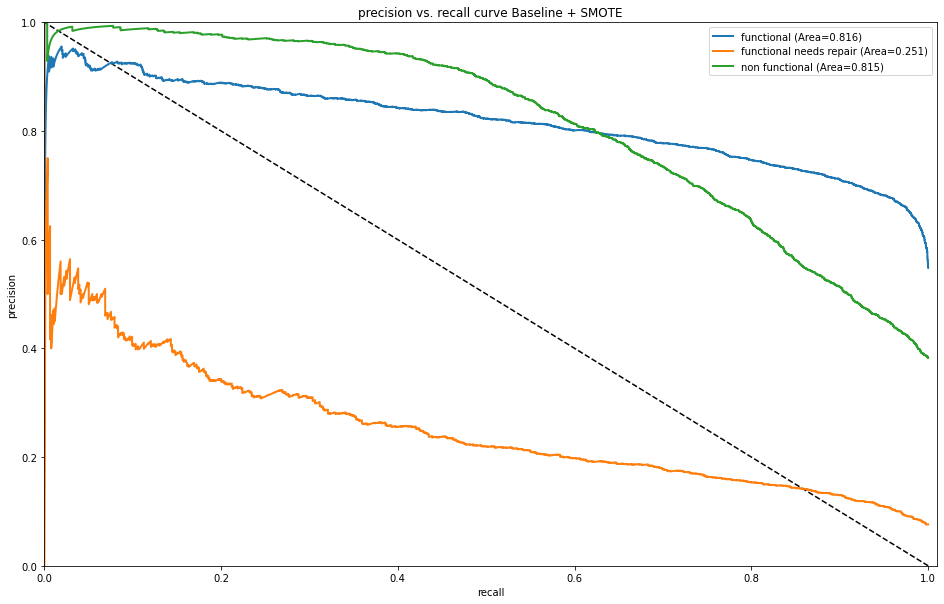

In [20]:
plot_multi_pr(logregsmote, y_test, 3, X_test, figsize=(16, 10), title='Baseline + SMOTE')

## Validate with the Validation Data

In [21]:
cross_val_score(logregsmote, validate.drop(columns='status_group'), validate.status_group).mean()

0.6286410037659829

In [22]:
val_preds = logregsmote.predict(validate.drop(columns='status_group'))
val_actual = validate.status_group

In [23]:
print(classification_report(val_actual, val_preds))

                         precision    recall  f1-score   support

             functional       0.78      0.60      0.68     10624
functional needs repair       0.16      0.63      0.25      1370
         non functional       0.79      0.62      0.70      7405

               accuracy                           0.61     19399
              macro avg       0.58      0.62      0.54     19399
           weighted avg       0.74      0.61      0.65     19399



## Summary

The recall score has vastly improved for the minority class as a result of implementing SMOTE.
However the overall performance of the model has decreased.

Positives from this model however are there is still no sign of overfitting, performance on training/test data is similar to the validation data set.